In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import optimize
import os
import sys
import csv
import math
import time

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from keras.layers.preprocessing import preprocessing_utils

In [ ]:
import cProfile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems

In [ ]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

In [ ]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/tns')
import operations
import networks
import tns_math
import tns_solve

In [ ]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/tns/test')
import test_tns

In [ ]:
import imp
imp.reload(sde_solve)
imp.reload(sde_systems)
imp.reload(operations)
imp.reload(networks)
imp.reload(tns_math)
imp.reload(test_tns)
imp.reload(tns_solve)

<module 'tns_solve' from '/content/gdrive/MyDrive/git/quantumML/python/tns/tns_solve.py'>

In [ ]:
with tf.GradientTape() as tape:
  a = tf.linalg.diag(v) + tf.ones([3,3], dtype=tf.float64)
  evals, _ = tf.linalg.eig(a)
  loss = evals[0] + evals[1]
  loss2 = loss + evals
  #loss = tf.matmul(a, tf.ones([3,1], dtype=tf.float64))

In [ ]:
grad = tape.gradient(loss2, v)
grad

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([3.52690487, 3.18674771, 2.28634742])>

In [ ]:
n = 6
-0.5 + math.sqrt(0.25 + 2.0*n)

3.0

In [ ]:
pdim = 3
x = tf.constant([1.0 + 0j, 2.0j, 3.0j, 4.0, 5.0j, 6.0])
x

<tf.Tensor: shape=(6,), dtype=complex128, numpy=array([1.+0.j, 0.+2.j, 0.+3.j, 4.+0.j, 0.+5.j, 6.+0.j])>

In [ ]:
#permidx = [int(pdim*ii + jj - ii*(ii+1)/2) if ii <= jj else int(pdim*jj + ii - jj*(jj+1)/2) for ii in range(pdim) for jj in range(pdim)]
permidx = [int(pdim*ii + jj - ii*(ii+1)/2) if ii <= jj else int(pdim*(pdim+1)/2) for ii in range(pdim) for jj in range(pdim)]
#x2 = [x[permidx[pdim*ii + jj]] if ii <= jj else tf.math.conj(x[permidx[pdim*ii + jj]]) for ii in range(pdim) for jj in range(pdim)]
x2 = tf.concat([x,tf.zeros(1, dtype=x.dtype)], axis=0)
x3 = tf.gather(x2, permidx)

In [ ]:
x4 = tf.reshape(x3, [pdim,pdim])
rho = (x4 + tf.transpose(x4, conjugate=True))*(tf.ones([pdim,pdim], dtype=x4.dtype) - 0.5*tf.linalg.eye(pdim, dtype=x4.dtype))
rho

<tf.Tensor: shape=(3, 3), dtype=complex128, numpy=
array([[1.+0.j, 0.+2.j, 0.+3.j],
       [0.-2.j, 4.+0.j, 0.+5.j],
       [0.-3.j, 0.-5.j, 6.+0.j]])>

In [ ]:
pdim = rho.shape[0]
vecsize = int(pdim*(pdim+1)/2)
rhovec = tf.reshape(rho, [-1])
permidx = tf.concat([[int(pdim*ii + jj) for ii in range(pdim) for jj in range(ii,pdim)], tf.zeros(int(pdim**2 - pdim*(pdim+1)/2), dtype=tf.int32)], axis=0)

In [ ]:
tf.gather(rhovec, permidx)[:vecsize]

<tf.Tensor: shape=(6,), dtype=complex128, numpy=array([1.+0.j, 0.+2.j, 0.+3.j, 4.+0.j, 0.+5.j, 6.+0.j])>

# MPS Learn

In [ ]:
epochs = 10
learning_rate = 0.01
losses = [init_loss]

for epoch in range(epochs):
  # Evaluate the loss function
  with tf.GradientTape() as tape:
    batch_loss = loss_func(emod(x_batch), y_batch)
  
  # Calculate the gradient and update
  grads = tape.gradient(batch_loss, emod.variables)
  for g, v in zip(grads, emod.variables):
    if g is not None:
      v.assign_sub(learning_rate*g)
  
  # Calculate the loss for this epoch
  losses.append(batch_loss)

  if epoch % 1 == 0:
    print(f'Loss for epoch {epoch} = {loss.numpy():0.3f}')
    print(emod.variables)

In [ ]:
2**(-10)

0.0009765625

# Composite Model

In [ ]:
def run_model(params, num_traj, deltat=2**(-8), comp_iq=True):
  #rho0 = tf.reshape(tf.ones([num_traj,1,1], dtype=tf.complex128)*tf.constant([[1.0,0],[0,0]], dtype=tf.complex128), [num_traj,4,1])
  #rho0 = tf.reshape(tf.ones([num_traj,1,1], dtype=tf.complex128)*tf.constant([[0.5,0.5],[0.5,0.5]], dtype=tf.complex128), [num_traj,4,1])
  x0 = tf.reshape(tf.ones([num_traj,1,1], dtype=tf.complex128)*tf.constant([1.0,0,0], dtype=tf.complex128), [num_traj,3,1])

  d = 3
  m = 2
  p = 10

  a = sde_systems.GenoisSDE.a
  b = sde_systems.GenoisSDE.b
  bp = sde_systems.GenoisSDE.bp

  mint = 0
  maxt = 1.0
  #deltat = 2**(-8)

  p0 = params
  #p0[1] = 0.1
  tvec = np.arange(mint,maxt,deltat)
  wvec = tf.cast(tf.random.normal(stddev=math.sqrt(deltat), shape=[num_traj,tvec.shape[0]-1,m,1]), dtype=x0.dtype)
  emod = sde_solve.EulerMultiDModel(mint, maxt, deltat, a, b, d, m, len(params), p0, [True, True, True], create_params=False)
  #params_ten = tf.tile(params[tf.newaxis,:], multiples=[num_traj,1])
  xvec = emod(x0, num_traj, wvec, params)
  rhovec = sde_systems.unwrap_x_to_rho(tf.reshape(tf.transpose(xvec, perm=[0,2,1]), [-1,3]), 2)
  rhovec = tf.transpose(tf.reshape(rhovec, [num_traj,-1,4]), perm=[0,2,1])

  tvec = emod.tvec
  #wvec = emod.wvec

  # Simulate the I voltage record
  if comp_iq:
    traj_sdes = sde_systems.GenoisTrajSDE(rhovec, deltat)
    ai = traj_sdes.mia
    bi = traj_sdes.mib
    bpi = traj_sdes.mibp
    emod_i = sde_solve.EulerMultiDModel(mint, maxt, deltat, ai, bi, 1, 1, len(params), p0, [True, True, True])
    ivec = emod_i(tf.zeros(1, dtype=tf.complex128), num_traj, wvec[:,:,0,0][:,:,tf.newaxis,tf.newaxis])

    # Simulate the Q voltage record
    aq = traj_sdes.mqa
    bq = traj_sdes.mqb
    bpq = traj_sdes.mqbp
    emod_q = sde_solve.EulerMultiDModel(mint, maxt, deltat, aq, bq, 1, 1, len(params), p0, [True, True, True])
    qvec = emod_q(tf.zeros(1, dtype=tf.complex128), num_traj, wvec[:,:,1,0][:,:,tf.newaxis,tf.newaxis])
  else:
    ivec = None
    qvec = None

  return rhovec, ivec, qvec, wvec, tvec

def get_probs(rhovec):
  sx, sy, sz = sde_systems.paulis()
  xvec = sde_systems.calc_exp(rhovec,sx)
  yvec = sde_systems.calc_exp(rhovec,sy)
  zvec = sde_systems.calc_exp(rhovec,sz)

  px = 0.5*(xvec+1)
  py = 0.5*(yvec+1)
  pz = 0.5*(zvec+1)

  return tf.stack([px, 1-px, py, 1-py, pz, 1-pz], axis=2)

In [ ]:
kappa = 2*0.55
#kappa = 0.1
# params = [Omega, Gamma, eta]
#params = np.array([1.0,0.2,1.0], dtype=np.cdouble)
params = np.array([5.0265,kappa,0.36], dtype=np.double)

num_traj=20
rhovec, ivec, qvec, wvec, tvec = run_model(params, num_traj, deltat=2**(-8))
#rhovec = run_model(params)[0]

/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_math_ops.py:6576: ComplexWarning: Casting complex values to real discards the imaginary part
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


In [ ]:
probs = get_probs(rhovec)
px = probs[:,:,0]
py = probs[:,:,2]
pz = probs[:,:,4]

In [ ]:
print(np.isnan(tf.reduce_max(tf.abs(tf.reduce_mean(probs, axis=0)))), tf.reduce_max(tf.reduce_mean(tf.math.real(probs), axis=0)), tf.reduce_min(tf.reduce_mean(tf.math.real(probs), axis=0)))
print(tf.reduce_max(tf.abs(tf.math.imag(tf.reduce_mean(probs, axis=0)))))

False tf.Tensor(1.0, shape=(), dtype=float64) tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)


In [ ]:
print(rhovec.shape)
print(ivec.shape)
print(qvec.shape)
print(probs.shape)

(20, 4, 256)
(20, 1, 256)
(20, 1, 256)
(20, 256, 6)


In [ ]:
truth_dict = {}
rabi_weak_meas.load_truth_data('/content/', truth_dict, 'T=4')

Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialX=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialZ=1_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialZ=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialY=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialX=1_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialY=1_T=4.0.dat


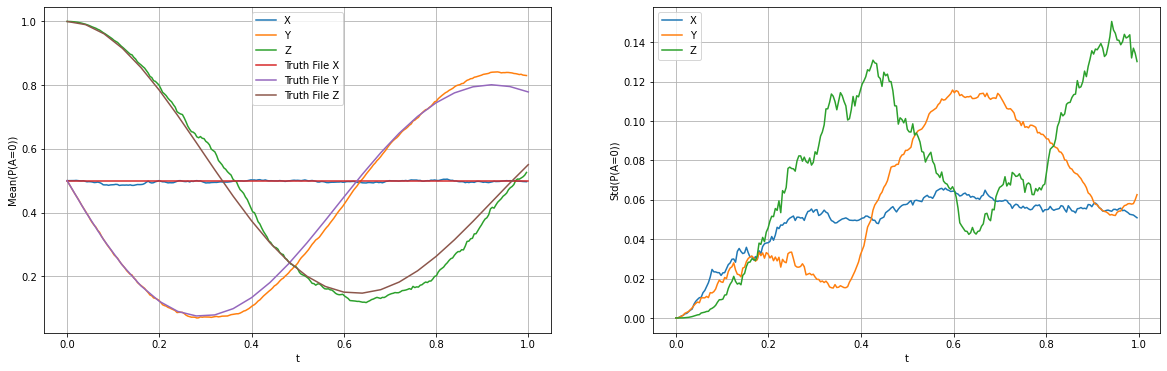

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(px), axis=0), label='X')
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(py), axis=0), label='Y')
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(pz), axis=0), label='Z')
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][0,:26], label='Truth File X')
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][1,:26], label='Truth File Y')
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][2,:26], label='Truth File Z')
#plt.legend(['X', 'Y', 'Z', 'Truth File X', 'Truth File Y', 'Truth File Z'])
plt.legend()
plt.xlabel('t')
plt.ylabel('Mean(P(A=0))')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, tf.math.reduce_std(tf.math.real(px), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(py), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(pz), axis=0))
plt.legend(['X', 'Y', 'Z'])
plt.xlabel('t')
plt.ylabel('Std(P(A=0))')
plt.grid()

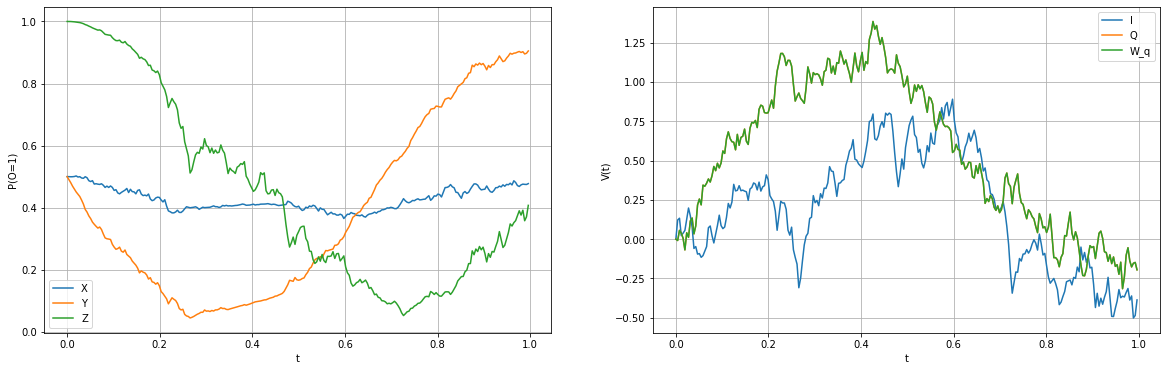

In [ ]:
traj_idx=1

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(tvec, tf.math.real(px[traj_idx,:]), label='X')
plt.plot(tvec, tf.math.real(py[traj_idx,:]), label='Y')
plt.plot(tvec, tf.math.real(pz[traj_idx,:]), label='Z')
plt.xlabel('t')
plt.ylabel('P(O=1)')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
wsum = [np.sum(tf.math.real(wvec[traj_idx,:tidx,1,0]).numpy()) for tidx in range(tvec.shape[0])]
plt.plot(tvec, tf.math.real(ivec[traj_idx,0,:]), label='I')
plt.plot(tvec, tf.math.real(qvec[traj_idx,0,:]), label='Q')
plt.plot(tvec, wsum, label='W_q')
plt.xlabel('t')
plt.ylabel('V(t)')
plt.legend()
plt.grid()

In [ ]:
ten = tf.ones([2,3])
ten = ten*[[1],[0]]
ten
tf.tile(ten, multiples=[2,1])

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]], dtype=float32)>

In [ ]:
# Generate training data
grp_size = 100
#kappas = np.arange(0.1,2.1,0.1)
kappas = np.array([1.1])
max_tries = 10
tol = 1e-5
imag_tol = 7e-2
batch_size = 10

voltage = None
all_probs = None
for kappa in kappas:
  print(f'kappa = {kappa}')
  for batch_idx in range(batch_size):
    print(f'Batch = {batch_idx}')
    params = np.array([5.0265,kappa,0.36], dtype=np.double)

    success = False
    num_tries = 0
    while not success and num_tries < max_tries:
      rhovec, ivec, qvec, wvec, tvec = run_model(params, grp_size, deltat=2**(-12))
      probs_traj = get_probs(rhovec)
      probs = tf.math.reduce_mean(probs_traj, axis=0)
      num_tries = num_tries + 1

      max_imag = tf.reduce_max(tf.abs(tf.math.imag(probs)))
      probs = tf.math.real(probs)
      max_prob = tf.reduce_max(probs)
      min_prob = tf.reduce_min(probs)
      if np.isnan(max_prob) or max_prob > 1.0 + tol or min_prob < -1.0*tol or max_imag > imag_tol:
        print(f'WARNING: Failed to generate valid probabilities for kappa = {kappa}, try {num_tries}/{max_tries}')
        print(f'Max prob: {max_prob}, Min prob: {min_prob}, Max imag: {max_imag}')
        continue
      
      success = True
      if voltage is None:
        voltage = ivec
        all_probs = probs[tf.newaxis,...]
      else:
        voltage = tf.concat((voltage, ivec), axis=1)
        all_probs = tf.concat((all_probs, probs[tf.newaxis,...]), axis=0)

    if not success:
      print(f'Failed for kappa={kappa}')
      break

  if not success:
    break

if success:
  voltage = tf.transpose(voltage, perm=[1,0,2])
else:
  voltage = None
  all_probs = None

print(f'Success = {success}')

kappa = 1.1
Batch = 0


/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_math_ops.py:6576: ComplexWarning: Casting complex values to real discards the imaginary part
  _result = pywrap_tfe.TFE_Py_FastPathExecute(


Batch = 1
Batch = 2
Batch = 3
Batch = 4
Batch = 5
Batch = 6
Batch = 7
Batch = 8
Batch = 9
Success = True


In [ ]:
success

True

In [ ]:
print(voltage.shape)
print(all_probs.shape)

(10, 100, 256)
(10, 256, 6)


In [ ]:
savedir = '/content/gdrive/MyDrive/Research/QML/models/kappa_1p1/voltage'
if not os.path.exists(savedir):
  os.makedirs(savedir)
v = tf.Variable(voltage)
tf.saved_model.save(v, savedir)

In [ ]:
savedir = '/content/gdrive/MyDrive/Research/QML/models/kappa_1p1/all_probs'
if not os.path.exists(savedir):
  os.makedirs(savedir)
v = tf.Variable(all_probs)
tf.saved_model.save(v, savedir)

In [ ]:
grp_size = 100
kappas = np.arange(0.1,2.1,0.1)
max_tries = 10
tol = 1e-5
imag_tol = 7e-2
batch_size = 10

mint = 0
maxt = 1.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)

voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/kappa_1p1/voltage'
all_probs_dir = '/content/gdrive/MyDrive/Research/QML/models/kappa_1p1/all_probs'
voltage = tf.saved_model.load(voltage_dir)
all_probs = tf.saved_model.load(all_probs_dir)

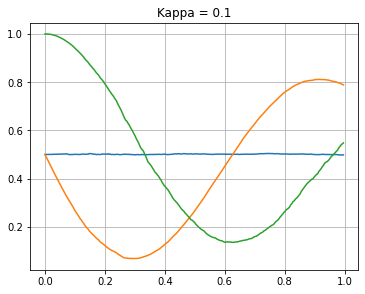

In [ ]:
plt.figure(figsize=[20,10])
for idx in range(1):
  plt.subplot(2,3,idx+1)
  plt.plot(tvec, all_probs[batch_size*idx,:,0])
  plt.plot(tvec, all_probs[batch_size*idx,:,2])
  plt.plot(tvec, all_probs[batch_size*idx,:,4])
  plt.title(f'Kappa = {kappas[idx]}')
  plt.grid()

In [ ]:
# Split training data
def split_data(data_x, data_y, train_frac):
    steps_per_val = int(1/(1 - train_frac))
    all_idcs = np.arange(data_x.shape[0])
    val_idcs = all_idcs[0::steps_per_val]
    train_idcs = np.delete(all_idcs, val_idcs)
    
    train_x = data_x[train_idcs, :, :]
    valid_x = data_x[val_idcs, :, :]
    
    train_y = data_y[train_idcs, :, :]
    valid_y = data_y[val_idcs, :, :]
    
    return train_x, valid_x, train_y, valid_y

In [ ]:
train_frac = 0.9
train_x, valid_x, train_y, valid_y = split_data(voltage.numpy(), all_probs.numpy(), train_frac)

In [ ]:
# Reshape so that each trajectory corresponds to a different batch element
train_x = np.reshape(train_x, [-1,train_x.shape[2]])[:,:,tf.newaxis]
valid_x = np.reshape(valid_x, [-1,valid_x.shape[2]])[:,:,tf.newaxis]
train_x = np.real(train_x)
train_y = np.real(train_y)
valid_x = np.real(valid_x)
valid_y = np.real(valid_y)

In [ ]:
train_y = tf.tile(train_y, multiples=[voltage.shape[1],1,1])
valid_y = tf.tile(valid_y, multiples=[voltage.shape[1],1,1])

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(900, 256, 1)
(900, 256, 6)
(100, 256, 1)
(100, 256, 6)


In [ ]:
class MySDELayer(tf.keras.layers.Layer):
  def __init__(self, num_traj, **kwargs):
    super(MySDELayer, self).__init__(**kwargs)
    self.num_traj=num_traj

  def call(self, inputs):
    #batch_size = K.shape(inputs)[0]
    params = np.array([5.0265,0.0,0.36], dtype=np.double)

    traj_inputs = tf.tile(inputs, multiples=[self.num_traj,1])[:,0]
    traj_inputs = tf.stack([params[0]*tf.ones(tf.shape(traj_inputs), dtype=traj_inputs.dtype), traj_inputs, params[2]*tf.ones(tf.shape(traj_inputs), dtype=traj_inputs.dtype)], axis=1)
    rhovecs = run_model(traj_inputs, num_traj=tf.shape(traj_inputs)[0], comp_iq=False)[0]
    probs = get_probs(rhovecs)

    probs_by_params = tf.reshape(probs, [tf.shape(inputs)[0], self.num_traj, tf.shape(probs)[1], tf.shape(probs)[2]])
    #mask = tf.math.logical_not(tf.math.is_nan(tf.reduce_max(tf.math.real(probs_by_params), axis=[2,3])))
    #probs_by_params = tf.boolean_mask(probs_by_params, mask)

    return tf.reduce_mean(probs_by_params, axis=1)

In [ ]:
# TODO - Handle NaNs returned by the model
num_traj = 100
inputs = tf.math.pow(dense_out[:,-1,:], 2)
params = np.array([5.0265,kappa,0.36], dtype=np.double)

traj_inputs = tf.tile(inputs, multiples=[num_traj,1])[:,0]
traj_inputs = tf.stack([params[0]*tf.ones(traj_inputs.shape, dtype=traj_inputs.dtype), traj_inputs, params[2]*tf.ones(traj_inputs.shape, dtype=traj_inputs.dtype)], axis=1)
rhovecs = run_model(traj_inputs, num_traj=traj_inputs.shape[0], comp_iq=False)[0]
probs = get_probs(rhovecs)

In [ ]:
probs_by_params = tf.reshape(probs, [inputs.shape[0], num_traj, probs.shape[1], probs.shape[2]])
mask = tf.math.logical_not(tf.math.is_nan(tf.reduce_max(tf.math.real(probs_by_params), axis=[2,3])))

In [ ]:
tf.boolean_mask(probs_by_params, mask).shape

TensorShape([18000, 256, 6])

In [ ]:
1890/tf.reduce_prod(sde_out.shape)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0068359375>

In [ ]:
sde_out.shape

TensorShape([180, 256, 6])

In [ ]:
mask = tf.math.logical_not(tf.math.is_nan(tf.reduce_max(tf.math.real(sde_out), axis=[1,2])))
tf.boolean_mask(sde_out, mask).shape

TensorShape([180, 256, 6])

In [ ]:
tf.reduce_sum(tf.cast(tf.math.is_nan(tf.math.real(sde_out)), dtype=tf.int32))

<tf.Tensor: shape=(), dtype=int32, numpy=1890>

In [ ]:
def qubit_crossentropy_loss(y_true, y_pred):
    #num_prep_states = prep_states.shape[0]
    num_prep_states = 36
    mask_value = -1
    num_traj = 1

    # Run the physical model on the output
    sde_layer = MySDELayer(num_traj)
    y_pred_ro_results = sde_layer(tf.math.pow(y_pred, 2))
    y_pred_ro_results = tf.reduce_mean(tf.math.real(y_pred_ro_results), axis=0)

    # Evaluate the cross entropy for each sample
    #y_true_prep_encoding = y_true[..., :num_prep_states]
    #y_true_ro_results = y_true[..., num_prep_states:]
    y_true_ro_results = tf.cast(y_true, y_pred_ro_results.dtype)

    return tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_true_ro_results[0,...], y_pred_ro_results))

    #batch_size = K.cast(K.shape(y_true_ro_results)[0], K.doublex())

    # Finds out where a readout is available
    #mask = K.cast(K.not_equal(y_true_ro_results, int(mask_value)), K.floatx())

    #pred_probs = K.reshape(tf.boolean_mask(y_pred_ro_results, mask), (batch_size, 2))
    #true_probs = K.reshape(tf.boolean_mask(y_true_ro_results, mask), (batch_size, 2))
    
    #cross_ent_x = K.categorical_crossentropy(y_true_ro_results[:,:,:2], y_pred_ro_results[:,:,:2], from_logits=False)
    #cross_ent_y = K.categorical_crossentropy(y_true_ro_results[:,:,2:4], y_pred_ro_results[:,:,2:4], from_logits=False)
    #cross_ent_z = K.categorical_crossentropy(y_true_ro_results[:,:,4:6], y_pred_ro_results[:,:,4:6], from_logits=False)
    #batch_size = tf.cast(K.shape(y_true_ro_results)[0], cross_ent_x.dtype)
    #return K.mean(cross_ent_x) + K.mean(cross_ent_y) + K.mean(cross_ent_z)

In [ ]:
def build_model(grp_size, seq_len, num_features, lmv, lstm_size, num_prep_states, num_params):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Input(shape=(seq_len, grp_size)))
    # Add a masking layer to handle different weak measurement sequence lengths
    #model.add(tf.keras.layers.Masking(mask_value=lmv, input_shape=(grp_size, seq_len, num_features)))
    
    # Add the LSTM layer
    # TODO - Do we need regularization parameters?
    model.add(tf.keras.layers.LSTM(lstm_size,
                                   batch_input_shape=(seq_len, num_features),
                                   dropout=0.0,
                                   stateful=False,
                                   return_sequences=False,
                                   name='lstm_layer'))
    
    # Add a dense layer for parameters
    prob_dist = tf.keras.layers.Dense(num_params, name='dense_layer')
    model.add(prob_dist)
    #model.add(tf.keras.layers.TimeDistributed(prob_dist))

    # Add the physical model layer that maps parameters to probabilities
    # The +1 on the input shape is for duration
    #model.add(MySDELayer(input_shape=(num_params + 1)))
    
    return model

def compile_model(model, num_prep_states, optimizer='adam'):
    model.compile(loss=qubit_crossentropy_loss, optimizer=optimizer)
#                  metrics=[masked_multi_prep_accuracy])

In [ ]:
lstm_layer = tf.keras.layers.LSTM(32,
                                   batch_input_shape=(train_x.shape[1],1),
                                   dropout=0.0,
                                   stateful=False,
                                   return_sequences=False,
                                   name='lstm_layer')
prob_dist = tf.keras.layers.Dense(1, name='dense_layer')
sde_layer = MySDELayer(1)

In [ ]:
train_x.dtype

dtype('float64')

In [ ]:
lstm_out = lstm_layer(np.real(train_x))

In [ ]:
dense_out = prob_dist(lstm_out)

In [ ]:
dense_out = tf.ones(dense_out.shape, dtype=dense_out.dtype)*math.sqrt(1.1)

In [ ]:
dense_out = model(train_x)

In [ ]:
sde_out = sde_layer(tf.math.pow(dense_out, 2))

In [ ]:
dense_out.shape

TensorShape([900, 1])

In [ ]:
print(train_x.shape)
print(dense_out.shape)
print(sde_out.shape)
print(train_y.shape)

(900, 256, 1)
(900, 1)
(900, 256, 6)
(900, 256, 6)


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


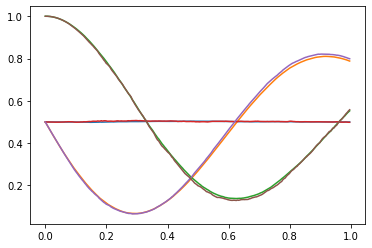

In [ ]:
sde_out_mean = tf.reduce_mean(sde_out, axis=0)
plt.plot(tvec, sde_out_mean[:,0])
plt.plot(tvec, sde_out_mean[:,2])
plt.plot(tvec, sde_out_mean[:,4])
plt.plot(tvec, train_y[0,:,0])
plt.plot(tvec, train_y[0,:,2])
plt.plot(tvec, train_y[0,:,4])

In [ ]:
#K.categorical_crossentropy(tf.math.real(sde_out[0,:,4:6]), train_y[0,:,4:6], from_logits=False)
tf.reduce_mean(tf.keras.metrics.mean_squared_error(tf.reduce_mean(tf.math.real(sde_out[:,:,:]), axis=0), train_y[0,:,:]))

<tf.Tensor: shape=(), dtype=float64, numpy=4.6169853636412694e-05>

In [ ]:
qubit_crossentropy_loss(train_y, dense_out)

<tf.Tensor: shape=(), dtype=float64, numpy=4.041813850161721e-05>

In [ ]:
tf.math.is_nan(tf.reduce_max(tf.math.real(sde_out)))

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [ ]:
# Build model
lmv = -1
_, seq_len, grp_size = train_x.shape
num_features = 1
num_params = 1
num_prep_states = 36
lstm_size = 32
model = build_model(grp_size, seq_len, num_features, lmv, lstm_size, num_prep_states, num_params)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)           (None, 32)                4352      
                                                                 
 dense_layer (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
compile_model(model, num_prep_states)

In [ ]:
train_x.shape

(900, 256, 1)

In [ ]:
# Train
mini_batch_size = 20
num_epochs = 10
verbose_level = 1

#lrscheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True)
#                    callbacks=[lrscheduler])

Epoch 1/10
45/45 [==============================] - 759s 2s/step - loss: 0.0024 - val_loss: 6.3365e-04
Epoch 2/10
45/45 [==============================] - 9s 204ms/step - loss: 7.2441e-04 - val_loss: 5.1601e-04
Epoch 3/10
45/45 [==============================] - 9s 202ms/step - loss: 6.2972e-04 - val_loss: 3.8403e-04
Epoch 4/10
45/45 [==============================] - 8s 184ms/step - loss: 5.3903e-04 - val_loss: 3.4790e-04
Epoch 5/10
45/45 [==============================] - 9s 204ms/step - loss: 5.1910e-04 - val_loss: 7.0506e-04
Epoch 6/10
45/45 [==============================] - 9s 202ms/step - loss: 4.7259e-04 - val_loss: 4.0316e-04
Epoch 7/10
45/45 [==============================] - 8s 187ms/step - loss: 4.4736e-04 - val_loss: 4.3579e-04
Epoch 8/10
45/45 [==============================] - 9s 196ms/step - loss: 4.2686e-04 - val_loss: 7.2271e-04
Epoch 9/10
45/45 [==============================] - 9s 202ms/step - loss: 5.0785e-04 - val_loss: 3.8602e-04
Epoch 10/10
45/45 [==============

In [ ]:
tf.pow(model.predict(train_x[:,...]), 2).shape

29/29 [==============================] - 1s 23ms/step


TensorShape([900, 1])

In [ ]:
qubit_crossentropy_loss(train_y, model(train_x))

<tf.Tensor: shape=(), dtype=float64, numpy=2.845350967839333e-05>

1.0224361 0.2852459
29/29 [==============================] - 1s 23ms/step


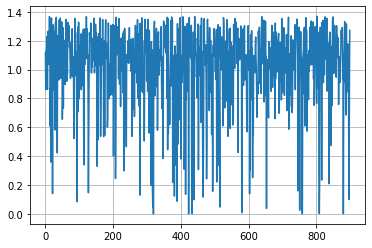

In [ ]:
print(tf.reduce_mean(tf.pow(model(train_x), 2)[:,0]).numpy(), tf.math.reduce_std(tf.pow(model(train_x), 2)[:,0]).numpy())
plt.plot(tf.pow(model.predict(train_x), 2)[:,0]);
plt.grid()

1.0437266 0.24087109
4/4 [==============================] - 0s 20ms/step


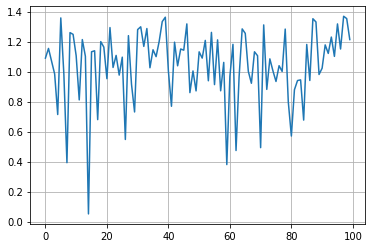

In [ ]:
print(tf.reduce_mean(tf.pow(model(valid_x), 2)[:,0]).numpy(), tf.math.reduce_std(tf.pow(model(valid_x), 2)[:,0]).numpy())
plt.plot(tf.pow(model.predict(valid_x), 2)[:,0]);
plt.grid()

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

total_size = 0.0
for name, size in sorted(((name, sys.getsizeof(eval(name))) for name in dir()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    total_size += size
print(total_size)

                           _i8:  2.3 KiB
                          tvec:  2.1 KiB
                           _69:  1.5 KiB
                          _i15:  1.5 KiB
                          _i37:  1.5 KiB
                          _i16:  1.4 KiB
                          _i38:  1.4 KiB
                           Out:  1.1 KiB
                           _oh:  1.1 KiB
                 Bidirectional:  1.0 KiB
15467.0


In [ ]:
import gc
gc.collect()

3773

# Genois Results

In [ ]:
import warnings

warnings.resetwarnings()

#warnings.simplefilter('error')

In [ ]:
num_traj=1000
rho0 = tf.reshape(tf.ones([num_traj,1,1], dtype=tf.complex128)*tf.constant([[1.0,0],[0,0]], dtype=tf.complex128), [num_traj,4,1])
#rho0 = tf.reshape(tf.ones([num_traj,1,1], dtype=tf.complex128)*tf.constant([[0.5,0.5],[0.5,0.5]], dtype=tf.complex128), [num_traj,4,1])

d = 4
m = 2
p = 10
# params = [Omega, Gamma, eta]
#params = np.array([1.0,0.2,1.0], dtype=np.cdouble)
params = np.array([5.0265,2*0.55,0.36], dtype=np.double)

a = sde_systems.GenoisSDE.a
b = sde_systems.GenoisSDE.b
bp = sde_systems.GenoisSDE.bp

mint = 0
maxt = 1.0
deltat = 2**(-8)

p0 = params
#p0[1] = 0.1
emod = sde_solve.EulerMultiDModel(mint, maxt, deltat, a, b, d, m, len(params), p0, [True, False, True])
rhovec = emod(rho0, num_traj)

tvec = emod.tvec

In [ ]:
sx, sy, sz = sde_systems.paulis()
xvec = sde_systems.calc_exp(rhovec,sx)
yvec = sde_systems.calc_exp(rhovec,sy)
zvec = sde_systems.calc_exp(rhovec,sz)

px = 0.5*(xvec+1)
py = 0.5*(yvec+1)
pz = 0.5*(zvec+1)

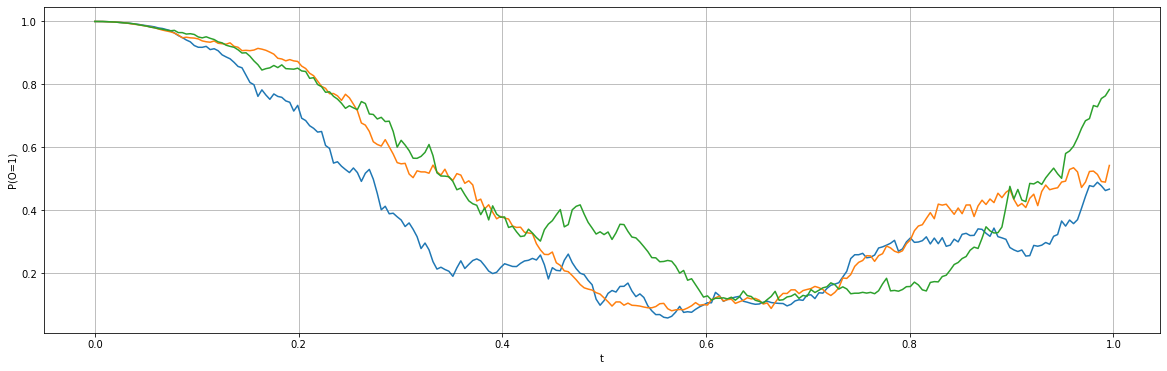

In [ ]:
traj_idx=2

plt.figure(figsize=(20,6))
plt.plot(tvec, tf.math.real(pz[traj_idx,:]))
plt.plot(tvec, tf.math.real(pz[traj_idx+1,:]))
plt.plot(tvec, tf.math.real(pz[traj_idx+2,:]))
plt.xlabel('t')
plt.ylabel('P(O=1)')
plt.grid()

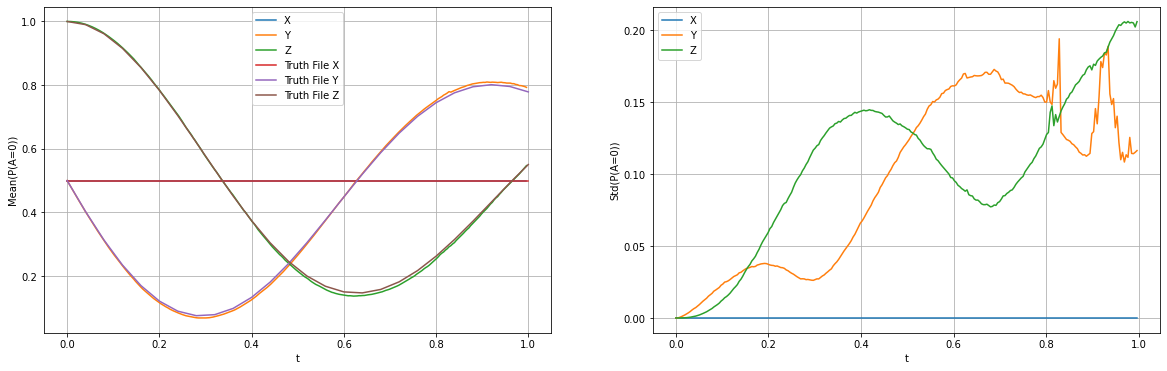

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(px), axis=0))
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(py), axis=0))
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(pz), axis=0))
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][0,:26])
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][1,:26])
plt.plot(truth_dict['time_axis'][:26], truth_dict['InitialZ=0'][2,:26])
plt.legend(['X', 'Y', 'Z', 'Truth File X', 'Truth File Y', 'Truth File Z'])
plt.xlabel('t')
plt.ylabel('Mean(P(A=0))')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, tf.math.reduce_std(tf.math.real(px), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(py), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(pz), axis=0))
plt.legend(['X', 'Y', 'Z'])
plt.xlabel('t')
plt.ylabel('Std(P(A=0))')
plt.grid()

In [ ]:
emod.variables

(<tf.Variable 'Variable:0' shape=() dtype=complex128, numpy=(5.0265+0j)>,
 <tf.Variable 'Variable:0' shape=() dtype=complex128, numpy=(0.1+0j)>,
 <tf.Variable 'Variable:0' shape=() dtype=complex128, numpy=(0.36+0j)>)

In [ ]:
yvec = emod(rho0, num_traj)
#print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

In [ ]:
tf.pow(3,2)

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [ ]:
losses = sde_solve.fit_model(rho0[0,:,0], rhovec, emod, sde_solve.md_mse_std_complex_loss, batch_size=100, epochs=1)

Init loss: tf.Tensor(0.08252366655565506, shape=(), dtype=float64)
tf.Tensor(-0.44835474597841346, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0070539375573677>
tf.Tensor(2.247612560105567, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.011537485017152>
tf.Tensor(-0.13768506058239766, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9890613594160962>
tf.Tensor(-0.6071298091032771, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9904382100219201>
tf.Tensor(-1.070115629833579, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.9965095081129529>
tf.Tensor(-1.2279531793737877, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0072106644112888>
tf.Tensor(-0.5348378162243225, shape=(), dtype=float64) <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0194901962050267>
tf.Tensor(-

In [ ]:
outvec = emod(rho0, num_traj)
sx, sy, sz = sde_systems.paulis()
xvec = sde_systems.calc_exp(outvec,sx)
yvec = sde_systems.calc_exp(outvec,sy)
zvec = sde_systems.calc_exp(outvec,sz)

px = 0.5*(xvec+1)
py = 0.5*(yvec+1)
pz = 0.5*(zvec+1)

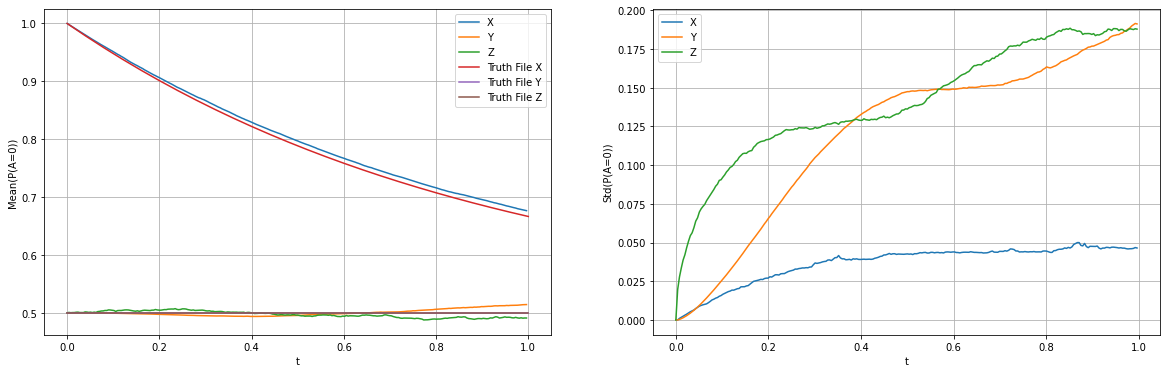

In [ ]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(px), axis=0))
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(py), axis=0))
plt.plot(tvec, tf.math.reduce_mean(tf.math.real(pz), axis=0))
plt.plot(truth_dict['time_axis'], truth_dict['InitialX=0'][0,:])
plt.plot(truth_dict['time_axis'], truth_dict['InitialX=0'][1,:])
plt.plot(truth_dict['time_axis'], truth_dict['InitialX=0'][2,:])
plt.legend(['X', 'Y', 'Z', 'Truth File X', 'Truth File Y', 'Truth File Z'])
plt.xlabel('t')
plt.ylabel('Mean(P(A=0))')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, tf.math.reduce_std(tf.math.real(px), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(py), axis=0))
plt.plot(tvec, tf.math.reduce_std(tf.math.real(pz), axis=0))
plt.legend(['X', 'Y', 'Z'])
plt.xlabel('t')
plt.ylabel('Std(P(A=0))')
plt.grid()

In [ ]:
mmod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4992174>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.10236108>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)

In [ ]:
yvec = mmod(x0, num_traj)
print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

0.0005828448588645179 0.00034688235814330496


# Load Truth Data

In [ ]:
def load_truth_file(filepath, return_dict):
    '''Loads a single tab delimited ground truth file'''
    
    print(f'Loading {filepath}')
    
    idx = filepath.find('Initial')
    prep_state = filepath[idx:idx+10]

    with open(filepath, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        rowidx = 0
        for row in reader:            
            if rowidx == 0:
                time_axis = np.array([x.split('_')[1] for x in row[1:] if len(x) > 0], dtype=np.float)
                if not 'time_axis' in return_dict.keys():
                    return_dict['time_axis'] = time_axis
                else:
                    tol = 1e-10
                    assert np.max(np.abs(return_dict['time_axis'] - time_axis)) < tol
            else:
                row_data = [x for x in row[1:] if len(x) > 0]
                if rowidx == 1:
                    true_probs = np.array(row_data, dtype=np.float)
                else:
                    true_probs = np.vstack((true_probs, np.array(row_data, dtype=np.float)))
                
            rowidx = rowidx + 1

    return_dict[prep_state] = true_probs

def load_truth_data(filedir, return_dict, filepath_key=None):
    '''
    A function for loading ground truth probability data from tab-delimited files
    '''

    for filename in os.listdir(filedir):
        filepath = os.path.join(filedir, filename)
        if os.path.isfile(filepath):
            if filename.endswith('.dat') and (filepath_key is None or filepath.find(filepath_key) >= 0):
                load_truth_file(filepath, return_dict)
        #elif os.path.isdir(filepath):
        #    load_truth_data(filepath, return_dict)
            
def truth_dict_to_probs(truth_dict):
    '''
    Takes the ground truth dictionary and returns an np.array with shape
    [num_prep_states, num_time_steps, num_meas]
    '''

    prep_states = ['InitialX=0', 'InitialX=1', 'InitialY=0', 'InitialY=1', 'InitialZ=0', 'InitialZ=1']

    probs = np.zeros((len(truth_dict.keys()) - 1, truth_dict['InitialX=0'].shape[1], 2*truth_dict['InitialX=0'].shape[0]))

    for prep_idx in range(len(prep_states)):
        probs[prep_idx,:,[0,2,4]] = truth_dict[prep_states[prep_idx]]
        probs[prep_idx,:,[1,3,5]] = 1 - truth_dict[prep_states[prep_idx]]

    return truth_dict['time_axis'], probs

In [ ]:
truth_dict = {}
load_truth_data('/content/', truth_dict, 'T=4')

Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialX=1_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialZ=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialY=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialZ=1_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialX=0_T=4.0.dat
Loading /content/GroundTruth_Qubit1_MeasurementEvery=0.04_kappa=0.55_InitialY=1_T=4.0.dat


<ipython-input-15-01486c8a27d6>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time_axis = np.array([x.split('_')[1] for x in row[1:] if len(x) > 0], dtype=np.float)
<ipython-input-15-01486c8a27d6>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  true_probs = np.array(row_data, dtype=np.float)
<ipython-input-15-01486c8a27d6>:25: Depre

In [ ]:
truth_dict['time_axis'][:26]
#truth_dict['InitialX=0'][0,:]

array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  ])

# Parameter Solving with Classes

In [ ]:
num_traj=10000
x0 = tf.constant([0.1,0.1])

d = 2
m = 2
p = 10
params = [1.5,1.5,0.1,0.1]

a = sde_systems.Geometric2DSDE.a
b = sde_systems.Geometric2DSDE.b
bp = sde_systems.Geometric2DSDE.bp

mint = 0
maxt = 1.0
deltat = 2**(-8)

p0 = params
p0[0] = 0.5
p0[2] = 0.4
mmod = sde_solve.MilsteinModel(mint, maxt, deltat, a, b, bp, d, m, p, len(params), p0, [False, True, False, True])
#yvec = mmod(x0, num_traj)

tvec = mmod.tvec

xmoment1 = 0.1*np.exp(1.5*tvec)
xmoment2 = 0.01*np.exp((301/100.0)*tvec)

In [ ]:
mmod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.4>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)

In [ ]:
yvec = mmod(x0, num_traj)
print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

0.10168630914382362 0.04485720789463666


In [ ]:
y = yvec

In [ ]:
losses = sde_solve.fit_model(x0, y, mmod, sde_solve.md_mse_std_loss, batch_size=1000)

Init loss: tf.Tensor(2.174137, shape=(), dtype=float32)
Loss for epoch 0 = 1.450
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.76257116>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.3383075>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 1 = 0.777
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0133016>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.2654612>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 2 = 0.308
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.219125>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.20195158>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 3 = 0.088
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.3

In [ ]:
mmod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4990622>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.098806724>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)

In [ ]:
yvec = mmod(x0, num_traj)
print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

0.000980740009804791 0.0006417243931673863


# SDE Classes

In [ ]:
class Geometric2DSDE:
  def __init__(self, c):
    self.c = c

  def a(self,t,x,p):
    return t+self.c

  def b(t,x,p):
    return tf.reshape(tf.constant([[1.0, 0.0],[0.0, 0.0]])*p[2] + tf.constant([[0.0, 0.0],[0.0, 1.0]])*p[3],[1,2,2])*x

  def bp(t,x,p):
    num_traj = x.shape[0]
    return tf.tile(tf.expand_dims(tf.stack([tf.constant([[1.0, 0.0],[0.0, 0.0]])*p[2],tf.constant([[0.0, 0.0],[0.0, 1.0]])*p[3]]), axis=0), [num_traj,1,1,1])


In [ ]:
o = Geometric2DSDE(2)

In [ ]:
oa = o.a

In [ ]:
oa(2,0,0)

4

In [ ]:
np.rint(1/0.25).astype(int)

4

# Milstein Compare

In [ ]:
num_traj=10000
x0 = 1.0

alpha = 1.5
beta = 1.0

def a(t,x,p):
  return p[0]*x

def b(t,x,p):
  return p[1]*x

def bp(t,x,p):
  return p[1]*tf.ones([x.shape[0],1,1,1])

mint = 0
maxt = 2.0
deltat = 2**(-6)

p = 10
p2 = 1

params = [1.5, 1.0]

emod = sde_solve.EulerMultiDModel(mint, maxt, deltat, a, b, 1, 1, len(params), params, [True, True])
mmod = sde_solve.MilsteinModel(mint, maxt, deltat, a, b, bp, 1, 1, p, len(params), params, [True, True])
mmod2 = sde_solve.MilsteinModel(mint, maxt, deltat, a, b, bp, 1, 1, p2, len(params), params, [True, True])

# Euler
yvec = emod(x0, num_traj)

#tvec = emod.tvec.numpy()
tvec = emod.tvec
wvec = emod.wvec.numpy()
#wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

# Milstein
myvec = mmod(x0, num_traj, emod.wvec)
myvec2 = mmod2(x0, num_traj, emod.wvec)

# Exact
xvec = x0*np.exp((alpha - 0.5*beta**2)*np.reshape(tvec,[1,-1])+beta*np.array([np.sum(wvec[:,:i,0,0],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
xdrift = x0*np.exp((alpha - 0.5*0.0**2)*tvec)
x0vec = np.ones([xvec.shape[0],1,1])*x0

In [ ]:
print(yvec.shape, myvec.shape, xvec.shape)

(10000, 1, 128) (10000, 1, 128) (10000, 128)


In [ ]:
print(sde_solve.abs_err_all(yvec[:,0,:], xvec)[0].numpy(), sde_solve.abs_err_all(myvec[:,0,:], xvec)[0].numpy(), sde_solve.abs_err_all(myvec2[:,0,:], xvec)[0].numpy())

1.942224 0.7366669 0.7366669


In [ ]:
print(sde_solve.mse_loss(yvec[:,0,:], xvec).numpy(), sde_solve.mse_loss(myvec[:,0,:], xvec).numpy(), sde_solve.mse_loss(myvec2[:,0,:], xvec).numpy())

7.091701 1.6366411 1.6366411


In [ ]:
print(sde_solve.mse_mean_loss(yvec[:,0,:], xvec).numpy(), sde_solve.mse_mean_loss(myvec[:,0,:], xvec).numpy(), sde_solve.mse_mean_loss(myvec2[:,0,:], xvec).numpy())

0.0641605 0.051016703 0.051016703


In [ ]:
min_traj=9000
max_traj=9100
print(sde_solve.mse_mean_loss(yvec[min_traj:max_traj,0,:], xvec[min_traj:max_traj]).numpy(), sde_solve.mse_mean_loss(myvec[min_traj:max_traj,0,:], xvec[min_traj:max_traj]).numpy(), sde_solve.mse_mean_loss(myvec2[min_traj:max_traj,0,:], xvec[min_traj:max_traj]).numpy())

1.0009098 0.20816782 0.20816782


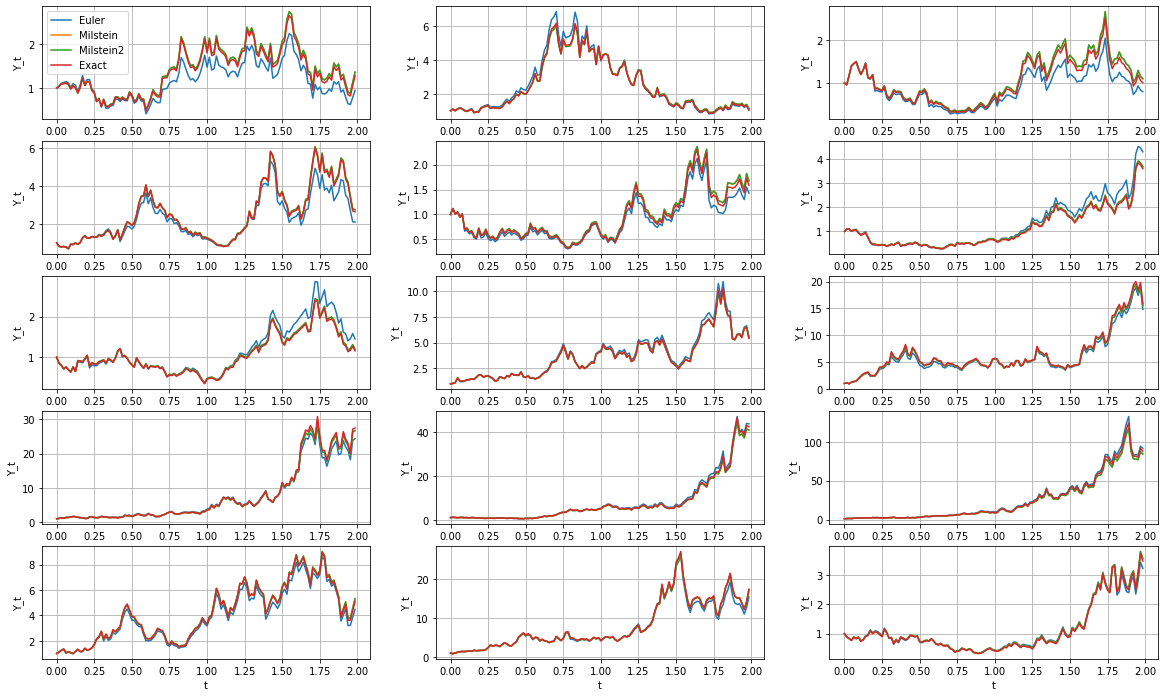

In [ ]:
plt.figure(figsize=(20,12))
min_traj = 8000
num_traj = 15
for traj_idx in range(num_traj):
  plt.subplot(5,3,traj_idx+1)
  plt.plot(tvec, yvec[min_traj+traj_idx,0,:], label='Euler')
  plt.plot(tvec, myvec[min_traj+traj_idx,0,:], label='Milstein')
  plt.plot(tvec, myvec2[min_traj+traj_idx,0,:], label='Milstein2')
  plt.plot(tvec, xvec[min_traj+traj_idx,:], label='Exact')
  plt.xlabel('t')
  plt.ylabel('Y_t')
  plt.grid()
  if traj_idx == 0:
    plt.legend()

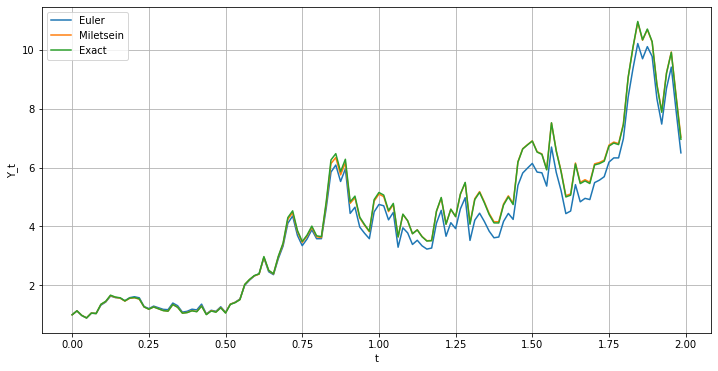

In [ ]:
traj_idx = 1
plt.figure(figsize=(12,6))
plt.plot(tvec, yvec[traj_idx,0,:])
plt.plot(tvec, myvec[traj_idx,0,:])
plt.plot(tvec, xvec[traj_idx,:])
#plt.plot(tvec[:-1], wvec[0,:])
#plt.plot(tvec, np.mean(myvec, axis=0)[0,:])
#plt.plot(tvec, np.mean(xvec, axis=0))
#plt.plot(tvec, xdrift)
plt.legend(['Euler', 'Miletsein','Exact'])
plt.xlabel('t')
plt.ylabel('Y_t')
plt.grid()

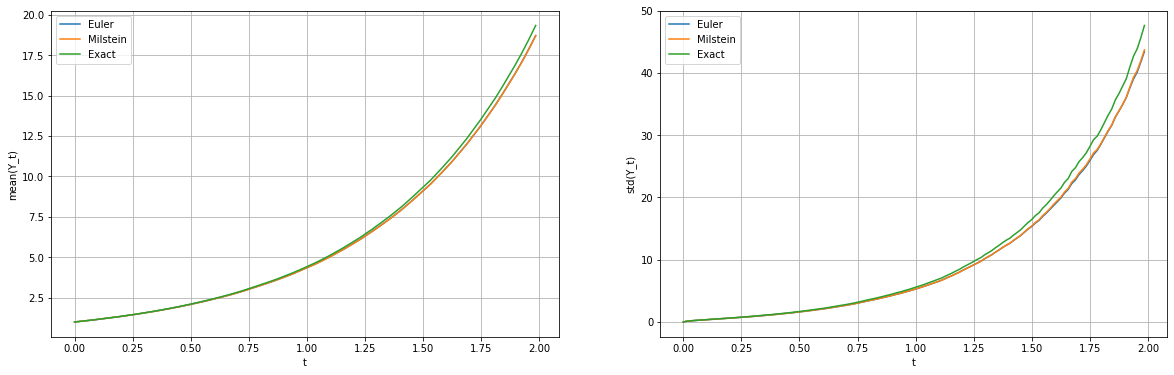

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
#plt.plot(tvec, yvec[2,:])
#plt.plot(tvec, xvec[2,:])
#plt.plot(tvec[:-1], wvec[0,:])
plt.plot(tvec, np.mean(yvec.numpy(), axis=0)[0,:], label='Euler')
plt.plot(tvec, np.mean(myvec.numpy(), axis=0)[0,:], label='Milstein')
plt.plot(tvec, np.mean(xvec, axis=0), label='Exact')
#plt.plot(tvec, xdrift, label='Drift')
plt.legend()
plt.xlabel('t')
plt.ylabel('mean(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.std(yvec.numpy(), axis=0)[0,:], label='Euler')
plt.plot(tvec, np.std(myvec.numpy(), axis=0)[0,:], label='Milstein')
plt.plot(tvec, np.std(xvec, axis=0), label='Exact')
plt.xlabel('t')
plt.ylabel('std(Y_t)')
plt.legend()
plt.grid()

# Scalar

In [ ]:
def euler_sde_np(x0,a,b,mint,maxt,deltat,num_traj=1):
  '''euler_sde_np: An SDE solver using the Euler scheme implemented with numpy.
                   Solves the SDE dX_t = a(t,X_t)dt + b(t,X_t)dW_t

  Args:
  x0: Initial value of the random process
  a: The drift function a(t,x)
  b: The diffusion function b(t,x)
  mint: Start time
  maxt: End time
  deltat: time step
  num_traj: Number of trajectories to simulate

  Returns:
  tvec: Time vector [mint:maxt:deltat], shape = [num_times]
  yvec: Simulated solutions, shape = [num_traj,num_times]
  wvec: Gaussian process samples used to simulate yvec, shape = [num_traj,num_times-1]
  '''

  tvec = np.arange(mint,maxt,deltat)
  yvec = np.zeros([num_traj,tvec.shape[0]])
  wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

  yvec[:,0] = x0
  for tidx, t in enumerate(tvec[:-1]):
    yvec[:,tidx+1] = yvec[:,tidx] + a(t,yvec[:,tidx])*deltat + b(t,yvec[:,tidx])*wvec[:,tidx]

  return tvec, yvec, wvec

In [ ]:
num_traj=100
x0 = 1.0

def a(t,x):
  return 1.5*x

def b(t,x):
  return 1.0*x

mint = 0
maxt = 1.0
deltat = 2**(-8)

tvec, yvec, wvec = euler_sde_np(x0,a,b,mint,maxt,deltat,num_traj)

xvec = x0*np.exp((a(0,1) - 0.5*b(0,1)**2)*np.reshape(tvec,[1,-1])+b(0,1)*np.array([np.sum(wvec[:,:i],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
xdrift = x0*np.exp((a(0,1) - 0.5*0.0**2)*tvec)

In [ ]:
print(abs(np.mean(yvec, axis=0)[-1] - np.mean(xvec, axis=0)[-1]))

0.00016404768258304614


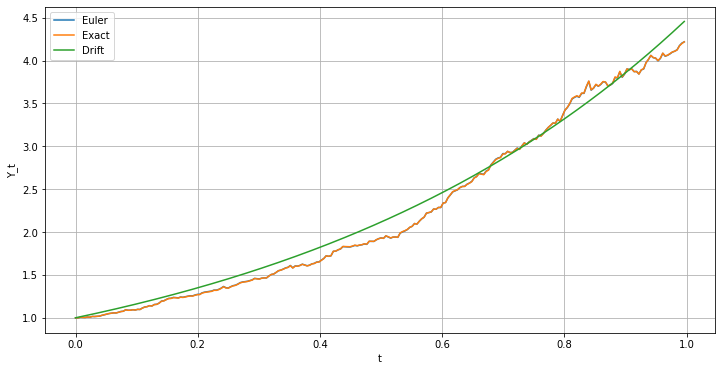

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(tvec, yvec[0,:])
#plt.plot(tvec, xvec[1,:])
#plt.plot(tvec[:-1], wvec[0,:])
plt.plot(tvec, np.mean(yvec, axis=0))
plt.plot(tvec, np.mean(xvec, axis=0))
plt.plot(tvec, xdrift)
plt.legend(['Euler', 'Exact', 'Drift'])
plt.xlabel('t')
plt.ylabel('Y_t')
plt.grid()

In [ ]:
def euler_sde_tf(x0,a,b,mint,maxt,deltat,num_traj=1):
  '''euler_sde_tf: An SDE solver using the Euler scheme implemented with TensorFlow.
                   Solves the SDE dX_t = a(t,X_t)dt + b(t,X_t)dW_t

  Args:
  x0: Initial value of the random process, shape = [None,1]
  a: The drift function a(t,x)
  b: The diffusion function b(t,x)
  mint: Start time
  maxt: End time
  deltat: time step
  num_traj: Number of trajectories to simulate

  Returns:
  tvec: Time vector [mint:maxt:deltat], shape = [num_times]
  yvec: Simulated solutions, shape = [None,num_times]
  wvec: Gaussian process samples used to simulate yvec, shape = [None,num_times-1]
  '''

  tvec = np.arange(mint,maxt,deltat)
  yvec = np.zeros([num_traj,tvec.shape[0]])
  wvec = np.zeros([num_traj,tvec.shape[0]-1])

  prevy = tf.ones(num_traj)*x0
  yvec[:,0] = prevy.numpy()

  for tidx, t in enumerate(tvec[:-1]):
    dw = tf.random.normal(stddev=math.sqrt(deltat), shape=[num_traj])
    curry = prevy + a(t,prevy)*deltat + b(t,prevy)*dw
    yvec[:,tidx+1] = curry.numpy()
    wvec[:,tidx] = dw.numpy()
    prevy = curry

  return tvec, yvec, wvec

In [ ]:
num_traj=100
x0 = 1.0

def a(t,x):
  return 1.5*x

def b(t,x):
  return 1.0*x

mint = 0
maxt = 1.0
deltat = 2**(-8)

tvec, yvec, wvec = euler_sde_tf(x0,a,b,mint,maxt,deltat,num_traj)

#wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

xvec = x0*np.exp((a(0,1) - 0.5*b(0,1)**2)*np.reshape(tvec,[1,-1])+b(0,1)*np.array([np.sum(wvec[:,:i],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
xdrift = x0*np.exp((a(0,1) - 0.5*0.0**2)*tvec)

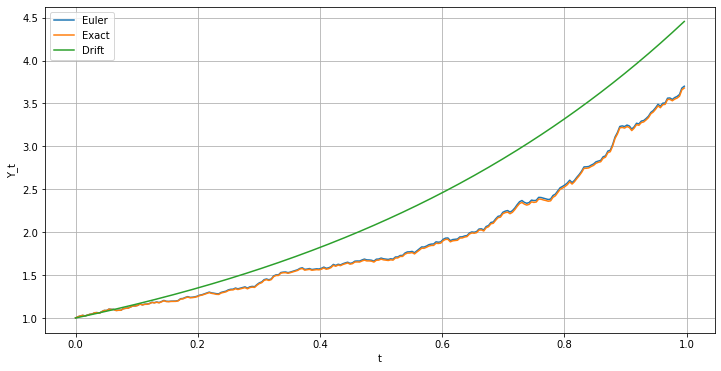

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(tvec, yvec[2,:])
#plt.plot(tvec, xvec[2,:])
#plt.plot(tvec[:-1], wvec[0,:])
plt.plot(tvec, np.mean(yvec, axis=0))
plt.plot(tvec, np.mean(xvec, axis=0))
plt.plot(tvec, xdrift)
plt.legend(['Euler', 'Exact', 'Drift'])
plt.xlabel('t')
plt.ylabel('Y_t')
plt.grid()

In [ ]:
v = tf.Variable(2)

In [ ]:
class EulerModel(tf.Module):

  def __init__(self, mint, maxt, deltat, a, b, num_params, params=None, fix_params=None):
    self.num_params = num_params
    self.params = []
    for pidx in range(self.num_params):
      # Randomly generate model parameters for those not provided
      if params is None or params[pidx] is None:
        self.params.append(tf.Variable(np.random.uniform()))
      else:
        self.params.append(tf.Variable(params[pidx], trainable=(fix_params is not None and not fix_params[pidx])))

    #self.tvec = tf.range(mint,maxt,deltat)
    self.tvec = np.arange(mint,maxt,deltat)
    self.deltat = deltat

    self.a = a
    self.b = b
  
  #@tf.function
  def __call__(self, x0, num_traj=None):
    if num_traj is None:
      num_traj = tf.shape(x0)[0]
    self.wvec = tf.random.normal(stddev=math.sqrt(self.deltat), shape=[num_traj,self.tvec.shape[0]-1])

    y = tf.ones(shape=[num_traj,1])*x0
    prevy = y

    for tidx, t in enumerate(self.tvec[:-1]):
      curry = prevy + self.a(t,prevy,self.params)*self.deltat + self.b(t,prevy,self.params)*tf.reshape(self.wvec[:,tidx], [num_traj,1])
      y = tf.concat([y, curry],1)
      prevy = curry

    return y


In [ ]:
num_traj=10000
x0 = 1.0

alpha = 1.5
beta = 1.0

def a(t,x,p):
  return p[0]*x

def b(t,x,p):
  return p[1]*x

mint = 0
maxt = 1.0
deltat = 2**(-8)

emod = EulerModel(mint, maxt, deltat, a, b, 2, [1.5, 1.0], [False, False])
yvec = emod(x0, num_traj)

#tvec = emod.tvec.numpy()
tvec = emod.tvec
wvec = emod.wvec.numpy()
#wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

xvec = x0*np.exp((alpha - 0.5*beta**2)*np.reshape(tvec,[1,-1])+beta*np.array([np.sum(wvec[:,:i],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
xdrift = x0*np.exp((alpha - 0.5*0.0**2)*tvec)
x0vec = np.ones([xvec.shape[0],1])*x0

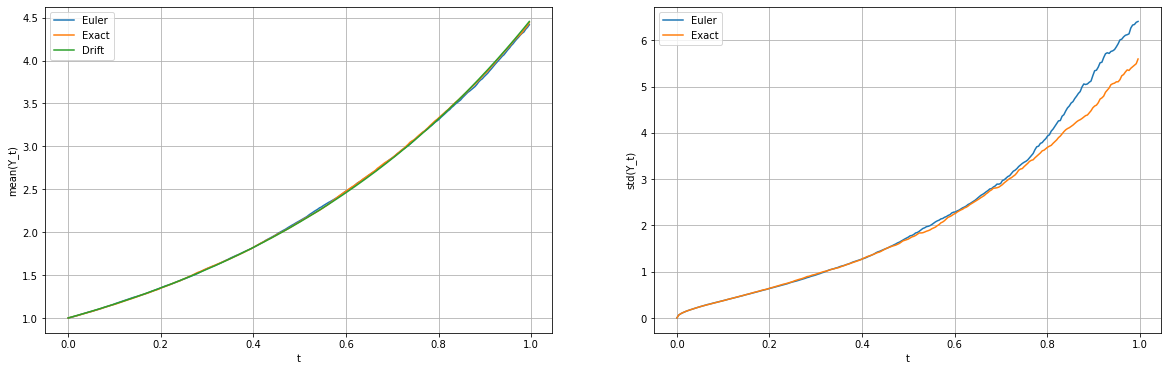

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
#plt.plot(tvec, yvec[2,:])
#plt.plot(tvec, xvec[2,:])
#plt.plot(tvec[:-1], wvec[0,:])
plt.plot(tvec, np.mean(emod(tf.cast(x0vec, dtype=tf.float32)).numpy(), axis=0), label='Euler')
plt.plot(tvec, np.mean(xvec, axis=0), label='Exact')
plt.plot(tvec, xdrift, label='Drift')
plt.legend()
plt.xlabel('t')
plt.ylabel('mean(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.std(emod(tf.cast(x0vec, dtype=tf.float32)).numpy(), axis=0), label='Euler')
plt.plot(tvec, np.std(xvec, axis=0), label='Exact')
plt.xlabel('t')
plt.ylabel('std(Y_t)')
plt.legend()
plt.grid()

In [ ]:
emod.params

ListWrapper([<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>])

In [ ]:
emod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>)

In [ ]:
def mse_mean_loss(y_pred, y):
  return tf.reduce_mean(tf.square(tf.reduce_mean(y_pred, axis=0) - tf.reduce_mean(tf.cast(y, dtype=tf.float32), axis=0)))

def mse_std_loss(y_pred, y):
  mean_loss = tf.reduce_mean(tf.square(tf.reduce_mean(y_pred, axis=0) - tf.reduce_mean(tf.cast(y, dtype=tf.float32), axis=0)))
  std_loss = tf.reduce_mean(tf.square(tf.math.reduce_std(y_pred, axis=0) - tf.math.reduce_std(tf.cast(y, dtype=tf.float32), axis=0)))

  return mean_loss + std_loss

def mse_var_loss(y_pred, y):
  mean_loss = tf.reduce_mean(tf.square(tf.reduce_mean(y_pred, axis=0) - tf.reduce_mean(tf.cast(y, dtype=tf.float32), axis=0)))
  var_loss = tf.reduce_mean(tf.square(tf.square(tf.math.reduce_std(y_pred, axis=0)) - tf.square(tf.math.reduce_std(tf.cast(y, dtype=tf.float32), axis=0))))

  return mean_loss + var_loss

def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.reduce_mean(tf.square(y_pred - y), axis=0))

def mse_mean_std_loss(y_pred, y):
  mean_loss = tf.reduce_mean(tf.reduce_mean(tf.square(y_pred - y), axis=0))
  std_loss = tf.reduce_mean(tf.math.reduce_std(tf.square(y_pred - y), axis=0))

  return mean_loss + std_loss

def abs_err(y_pred, y, batch_size):
  m = tf.shape(y_pred)[0]/batch_size
  batch_means = tf.reduce_mean(tf.reshape(tf.math.abs(y_pred - y), [tf.cast(m, dtype=tf.int32), -1, tf.shape(y_pred)[1]]), axis=1)
  err = tf.reduce_mean(batch_means, axis=0)
  std = tf.math.reduce_std(batch_means, axis=0)

  return err, std, std/tf.cast(tf.math.sqrt(m), dtype=tf.float32)

def abs_err_all(y_pred, y):
  mean = tf.reduce_mean(tf.math.abs(y_pred - y)[:,-1])
  sigma = tf.math.reduce_std(tf.math.abs(y_pred - y)[:,-1])
  return mean, sigma, sigma/tf.math.sqrt(tf.cast(tf.shape(y_pred)[0], dtype=tf.float32))

def abs_err_loss(y_pred, y):
  return tf.reduce_mean(tf.math.abs(y_pred - y)[:,-1])

def mean_abs_err_loss(y_pred, y):
  return tf.reduce_mean(tf.reduce_mean(tf.math.abs(y_pred - y), axis=0))

In [ ]:
print(mse_mean_loss(yvec, xvec), mse_std_loss(yvec, xvec), mse_var_loss(yvec, xvec), mse_loss(yvec, xvec), mse_mean_std_loss(yvec, xvec), abs_err_loss(yvec, xvec), mean_abs_err_loss(yvec, xvec))
print('Abs err:', abs_err_loss(yvec, xvec).numpy())
loss_func = mse_std_loss
init_loss = loss_func(yvec, xvec)
init_loss

tf.Tensor(7.70176e-05, shape=(), dtype=float32) tf.Tensor(0.0010229296, shape=(), dtype=float32) tf.Tensor(0.06252074, shape=(), dtype=float32) tf.Tensor(0.019773424, shape=(), dtype=float32) tf.Tensor(0.1574762, shape=(), dtype=float32) tf.Tensor(0.1547575, shape=(), dtype=float32) tf.Tensor(0.06226252, shape=(), dtype=float32)
Abs err: 0.1547575


<tf.Tensor: shape=(), dtype=float32, numpy=0.0010229296>

In [ ]:
abs_err_est, abs_err_std, delta_eps = abs_err(yvec, xvec, 100)
abs_err_all_est, abs_err_all_std, delta_eps_all = abs_err_all(yvec, xvec)
print(abs_err_est[-1].numpy(), abs_err_std[-1].numpy(), delta_eps[-1].numpy())
print(abs_err_all_est.numpy(), abs_err_all_std.numpy(), delta_eps_all.numpy())

0.15475748 0.027373103 0.0027373102
0.1547575 0.26614562 0.0026614561


In [ ]:
batch_size = 1000
dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x0vec, dtype=tf.float32), tf.cast(xvec, dtype=tf.float32)))
dataset = dataset.shuffle(buffer_size=x0vec.shape[0]).batch(batch_size)

In [ ]:
epochs = 10
learning_rate = 0.01
losses = [init_loss]

for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    # Evaluate the loss function
    with tf.GradientTape() as tape:
      batch_loss = loss_func(emod(x_batch), y_batch)
    
    # Calculate the gradient and update
    grads = tape.gradient(batch_loss, emod.variables)
    for g, v in zip(grads, emod.variables):
      if g is not None:
        v.assign_sub(learning_rate*g)
  
  # Calculate the loss for this epoch
  loss = loss_func(emod(tf.cast(x0vec, dtype=tf.float32)), xvec)
  losses.append(loss)

  if epoch % 1 == 0:
    print(f'Loss for epoch {epoch} = {loss.numpy():0.3f}')
    print(emod.variables)

Loss for epoch 0 = 4.266
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.8580852>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6346812>)
Loss for epoch 1 = 0.213
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.2781936>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0758672>)
Loss for epoch 2 = 0.078
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4199417>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.1197231>)
Loss for epoch 3 = 0.025
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.437879>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0157166>)
Loss for epoch 4 = 0.125
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4585129>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.96056515>)
Loss for epoch 5 = 0.039
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5689611>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.94915223>)
Loss for epoch 6 = 0.081
(<

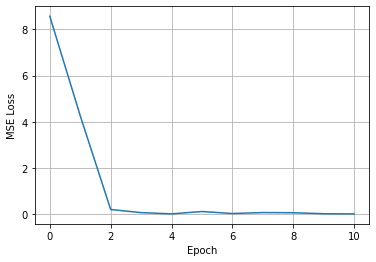

In [ ]:
plt.plot(range(epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()

In [ ]:
emod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5787976>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.9701483>)

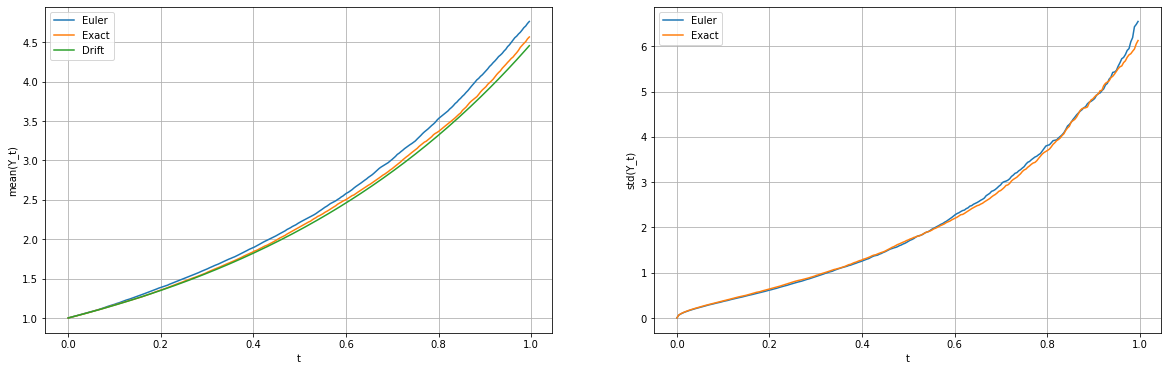

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
#plt.plot(tvec, yvec[2,:])
#plt.plot(tvec, xvec[2,:])
#plt.plot(tvec[:-1], wvec[0,:])
plt.plot(tvec, np.mean(emod(tf.cast(x0vec, dtype=tf.float32)).numpy(), axis=0), label='Euler')
plt.plot(tvec, np.mean(xvec, axis=0), label='Exact')
plt.plot(tvec, xdrift, label='Drift')
plt.legend()
plt.xlabel('t')
plt.ylabel('mean(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.std(emod(tf.cast(x0vec, dtype=tf.float32)).numpy(), axis=0), label='Euler')
plt.plot(tvec, np.std(xvec, axis=0), label='Exact')
plt.xlabel('t')
plt.ylabel('std(Y_t)')
plt.legend()
plt.grid()

# Multi-Dimensional

In [ ]:
class EulerMultiDModel(tf.Module):

  def __init__(self, mint, maxt, deltat, a, b, d, m, num_params, params=None, fix_params=None):
    self.num_params = num_params
    self.params = []
    for pidx in range(self.num_params):
      # Randomly generate model parameters for those not provided
      if params is None or params[pidx] is None:
        self.params.append(tf.Variable(np.random.uniform()))
      else:
        self.params.append(tf.Variable(params[pidx], trainable=(fix_params is not None and not fix_params[pidx])))

    #self.tvec = tf.range(mint,maxt,deltat)
    self.tvec = np.arange(mint,maxt,deltat)
    self.deltat = deltat

    self.a = a
    self.b = b

    self.d = d
    self.m = m
  
  @tf.function
  def __call__(self, x0, num_traj=None):
    if num_traj is None:
      num_traj = tf.shape(x0)[0]
    self.wvec = tf.random.normal(stddev=math.sqrt(self.deltat), shape=[num_traj,self.m,1,self.tvec.shape[0]-1])

    prevy = tf.ones(shape=[num_traj,self.d,1])*tf.reshape(x0,[-1,self.d,1])
    y = tf.reshape(prevy, [num_traj,self.d,1])

    for tidx, t in enumerate(self.tvec[:-1]):
      curry = prevy + self.a(t,prevy,self.params)*self.deltat + tf.matmul(self.b(t,prevy,self.params),self.wvec[:,:,:,tidx])
      y = tf.concat([y, curry], axis=2)
      prevy = curry

    return y


In [ ]:
num_traj=10000
x0 = [0.1,0.1]

d = 2
m = 2
params = [1.5,1.5,0.1,0.1]

def a(t,x,p):
  return tf.reshape((tf.constant([[1.0],[0.0]])*p[0] + tf.constant([[0.0],[1.0]])*p[1]), [1,2,1])*x

def b(t,x,p):
  return tf.reshape(tf.constant([[1.0, 0.0],[0.0, 0.0]])*p[2] + tf.constant([[0.0, 0.0],[0.0, 1.0]])*p[3],[1,2,2])*x

mint = 0
maxt = 1.0
deltat = 2**(-8)

p0 = params
p0[0] = 0.5
p0[2] = 0.4
emod = sde_solve.EulerMultiDModel(mint, maxt, deltat, a, b, d, m, len(params), p0, [False, True, False, True])
yvec = emod(x0, num_traj)

#tvec = emod.tvec.numpy()
tvec = emod.tvec
#wvec = emod.wvec.numpy()
#wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

#xvec = yvec
#xvec = x0*np.exp((alpha - 0.5*beta**2)*np.reshape(tvec,[1,-1])+beta*np.array([np.sum(wvec[:,:i],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
#xdrift = x0*np.exp((alpha - 0.5*0.0**2)*tvec)
#x0vec = np.ones([xvec.shape[0],1])*x0
xmoment1 = 0.1*np.exp(1.5*tvec)
xmoment2 = 0.01*np.exp((301/100.0)*tvec)

In [ ]:
xvec = yvec
x0vec = np.ones([xvec.shape[0],1])*x0

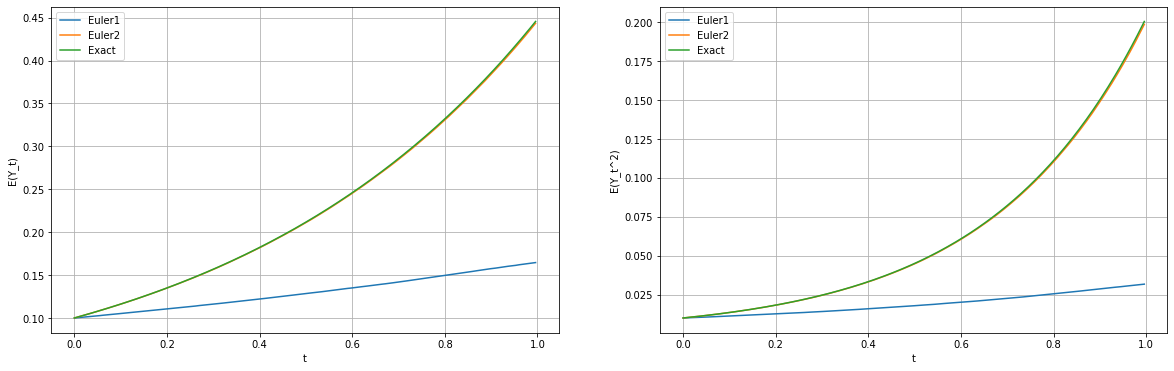

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(tvec, np.mean(yvec.numpy(), axis=0)[0,:], label='Euler1')
plt.plot(tvec, np.mean(yvec.numpy(), axis=0)[1,:], label='Euler2')
plt.plot(tvec, xmoment1, label='Exact')
plt.legend()
plt.xlabel('t')
plt.ylabel('E(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.mean(np.square(yvec.numpy()), axis=0)[0,:], label='Euler1')
plt.plot(tvec, np.mean(np.square(yvec.numpy()), axis=0)[1,:], label='Euler2')
plt.plot(tvec, xmoment2, label='Exact')
plt.xlabel('t')
plt.ylabel('E(Y_t^2)')
plt.legend()
plt.grid()

In [ ]:
print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

0.0005482946810471345 0.00035153378641407065


In [ ]:
def md_mse_std_loss(y_pred, y):
  mean_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.reduce_mean(y_pred, axis=0) - tf.reduce_mean(tf.cast(y, dtype=tf.float32), axis=0)), axis=1))
  std_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.math.reduce_std(y_pred, axis=0) - tf.math.reduce_std(tf.cast(y, dtype=tf.float32), axis=0)), axis=1))

  return mean_loss + std_loss

In [ ]:
loss_func = sde_solve.md_mse_std_loss
init_loss = loss_func(yvec, xvec)
init_loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.1587832>

In [ ]:
batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x0vec, dtype=tf.float32), tf.cast(xvec, dtype=tf.float32)))
dataset = dataset.shuffle(buffer_size=x0vec.shape[0]).batch(batch_size)

In [ ]:
epochs = 10
learning_rate = 0.01
losses = [init_loss]

for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    # Evaluate the loss function
    with tf.GradientTape() as tape:
      batch_loss = loss_func(emod(x_batch), y_batch)
    
    # Calculate the gradient and update
    grads = tape.gradient(batch_loss, emod.variables)
    for g, v in zip(grads, emod.variables):
      if g is not None:
        v.assign_sub(learning_rate*g)
  
  # Calculate the loss for this epoch
  loss = loss_func(emod(tf.cast(x0vec, dtype=tf.float32)), xvec)
  losses.append(loss)

  if epoch % 1 == 0:
    print(f'Loss for epoch {epoch} = {loss.numpy():0.3f}')
    print(emod.variables)

Loss for epoch 0 = 1.425
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.7590319>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.34464636>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 1 = 0.810
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0066701>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.27349976>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 2 = 0.333
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.2081002>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.20526738>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)
Loss for epoch 3 = 0.095
(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.3497539>, <tf.Variable 'Variable:0' shape=() dtype=floa

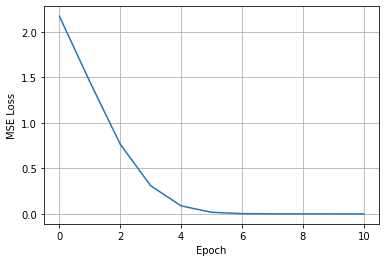

In [ ]:
plt.plot(range(epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()

In [ ]:
emod.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.4996524>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.10122257>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)

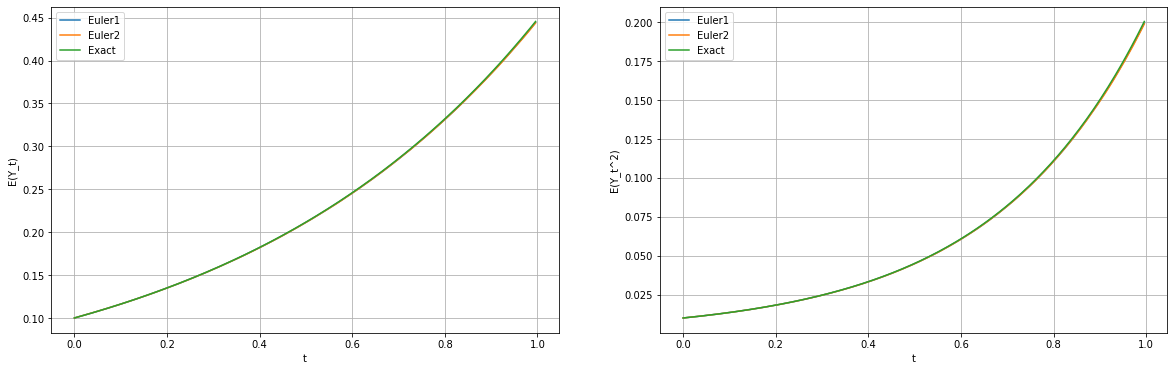

In [ ]:
predvec = emod(tf.cast(x0vec, dtype=tf.float32))

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(tvec, np.mean(predvec.numpy(), axis=0)[0,:], label='Euler1')
plt.plot(tvec, np.mean(predvec.numpy(), axis=0)[1,:], label='Euler2')
plt.plot(tvec, xmoment1, label='Exact')
plt.legend()
plt.xlabel('t')
plt.ylabel('E(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.mean(np.square(predvec.numpy()), axis=0)[0,:], label='Euler1')
plt.plot(tvec, np.mean(np.square(predvec.numpy()), axis=0)[1,:], label='Euler2')
plt.plot(tvec, xmoment2, label='Exact')
plt.xlabel('t')
plt.ylabel('E(Y_t^2)')
plt.legend()
plt.grid()

In [ ]:
def getrhop(p):
  rhop = 0.0
  for r in range(1,p+1):
    rhop = rhop + 1/float(r*r)
  rhop = (1/12.0) - rhop/(2*math.pi**2)
  return rhop

def multiintj12(m,p,deltat,wvec):
  '''
  Returns:
  jmat - [num_traj,num_times-1,m,m]
  '''

  num_traj = wvec.shape[0]
  num_times = wvec.shape[-1] + 1

  gsi = wvec/math.sqrt(deltat)
  mu = tf.random.normal(stddev=1.0, shape=[num_traj,num_times-1,m,1])
  eta = tf.random.normal(stddev=1.0, shape=[num_traj,num_times-1,m,1,p])
  zeta = tf.random.normal(stddev=1.0, shape=[num_traj,num_times-1,m,1,p])

  sumval = tf.zeros([num_traj,num_times-1,m,m])
  rhop = 0.0
  for ridx in range(p):
    r = ridx + 1
    sumval = sumval + float(1/r)*(tf.matmul(zeta[:,:,:,:,ridx], tf.transpose(math.sqrt(2)*gsi + eta[...,ridx], perm=[0,1,3,2])))
    rhop = rhop + 1/float(r*r)

  sumval = (sumval - tf.transpose(sumval, perm=[0,1,3,2]))
  rhop = (1/12.0) - rhop/(2*math.pi**2)
  jmat = sumval*deltat/math.pi
  jmat = jmat + deltat*(0.5*tf.matmul(gsi, tf.transpose(gsi, perm=[0,1,3,2])) + \
                        math.sqrt(rhop)*(tf.matmul(mu, tf.transpose(gsi, perm=[0,1,3,2])) - tf.matmul(gsi, tf.transpose(mu, perm=[0,1,3,2]))))
  jmat = jmat - jmat*tf.eye(m,m,[num_traj,num_times-1]) # Zero out the diagonal
  return jmat

class MilsteinModel(tf.Module):

  def __init__(self, mint, maxt, deltat, a, b, bp, d, m, p, num_params, params=None, fix_params=None):
    '''
    Input functions defining the SDE:
    a - Returns [num_traj,d,1] drift function of t and x([num_traj,d,1])
    b - Returns [num_traj,d,m] diffusion functions of t and x([num_traj,d,1])
    bp - Returns [num_traj,m,d,d] Jacobians of b_j w.r.t. x (shape [d,d]), where the second index indicates
         which column of b is being differentiated. Is a function of t and x([num_traj,d,1])
    '''
    self.num_params = num_params
    self.params = []
    for pidx in range(self.num_params):
      # Randomly generate model parameters for those not provided
      if params is None or params[pidx] is None:
        self.params.append(tf.Variable(np.random.uniform()))
      else:
        self.params.append(tf.Variable(params[pidx], trainable=(fix_params is not None and not fix_params[pidx])))

    #self.tvec = tf.range(mint,maxt,deltat)
    self.tvec = np.arange(mint,maxt,deltat)
    self.deltat = deltat

    self.a = a
    self.b = b
    self.bp = bp

    self.d = d
    self.m = m

    self.p = p
  
  @tf.function
  def __call__(self, x0, num_traj=None):
    if num_traj is None:
      num_traj = tf.shape(x0)[0]
    
    num_times = self.tvec.shape[0]
    self.wvec = tf.random.normal(stddev=math.sqrt(self.deltat), shape=[num_traj,num_times-1,self.m,1])

    self.jmat = multiintj12(m, self.p, self.deltat, self.wvec) # [num_traj,num_times-1,m,m]
    self.imat = 0.5*tf.eye(self.m, self.m, [num_traj,num_times-1])*(tf.matmul(self.wvec, tf.transpose(self.wvec, perm=[0,1,3,2])) - self.deltat) + self.jmat # [num_traj,num_times-1,m,m]

    prevy = tf.ones(shape=[num_traj,self.d,1])*tf.reshape(x0,[-1,self.d,1])
    y = tf.reshape(prevy, [num_traj,self.d,1])

    for tidx, t in enumerate(self.tvec[:-1]):
      # y_n+1 = y_n + Drift \ Euler \ Milstein
      bb = self.b(t,prevy,self.params) # [num_traj,d,m]
      lb = tf.matmul(tf.reshape(tf.transpose(bb, perm=[0,2,1]), [num_traj,1,self.m,self.d]), self.bp(t,prevy,self.params)) # [num_traj,m,m,d], indices = [i,j2,j1,k]
      lb = tf.transpose(lb, perm=[0,3,2,1]) # [num_traj,d,m,m], indices = [i,k,j1,j2]
      
      curry = prevy + self.a(t,prevy,self.params)*self.deltat + \
              tf.matmul(bb,self.wvec[:,tidx,:,:]) + \
              tf.expand_dims(tf.reduce_sum(lb*tf.expand_dims(self.imat[:,tidx,:,:], 1), axis=[2,3]), -1)
      y = tf.concat([y, curry], axis=2)
      prevy = curry

    return y


In [ ]:
num_traj=10000
x0 = [0.1,0.1]

d = 2
m = 2
p = 10
params = [1.5,1.5,0.1,0.1]

def a(t,x,p):
  return tf.reshape((tf.constant([[1.0],[0.0]])*p[0] + tf.constant([[0.0],[1.0]])*p[1]), [1,2,1])*x

def b(t,x,p):
  return tf.reshape(tf.constant([[1.0, 0.0],[0.0, 0.0]])*p[2] + tf.constant([[0.0, 0.0],[0.0, 1.0]])*p[3],[1,2,2])*x

def bp(t,x,p):
  num_traj = x.shape[0]
  return tf.tile(tf.expand_dims(tf.stack([tf.constant([[1.0, 0.0],[0.0, 0.0]])*p[2],tf.constant([[0.0, 0.0],[0.0, 1.0]])*p[3]]), axis=0), [num_traj,1,1,1])

mint = 0
maxt = 1.0
deltat = 2**(-8)

p0 = params
p0[0] = 0.5
p0[2] = 0.4
emod = sde_solve.MilsteinModel(mint, maxt, deltat, a, b, bp, d, m, p, len(params), p0, [False, True, False, True])
yvec = emod(x0, num_traj)

#tvec = emod.tvec.numpy()
tvec = emod.tvec
#wvec = emod.wvec.numpy()
#wvec = np.random.default_rng().normal(scale=math.sqrt(deltat), size=[num_traj,tvec.shape[0]-1])

#xvec = x0*np.exp((alpha - 0.5*beta**2)*np.reshape(tvec,[1,-1])+beta*np.array([np.sum(wvec[:,:i],axis=1) for i in range(wvec.shape[1]+1)]).transpose())
#xdrift = x0*np.exp((alpha - 0.5*0.0**2)*tvec)
#x0vec = np.ones([xvec.shape[0],1])*x0
xmoment1 = 0.1*np.exp(1.5*tvec)
xmoment2 = 0.01*np.exp((301/100.0)*tvec)

In [ ]:
xvec = yvec
x0vec = np.ones([xvec.shape[0],1])*x0

In [ ]:
xvec.shape

TensorShape([10000, 2, 256])

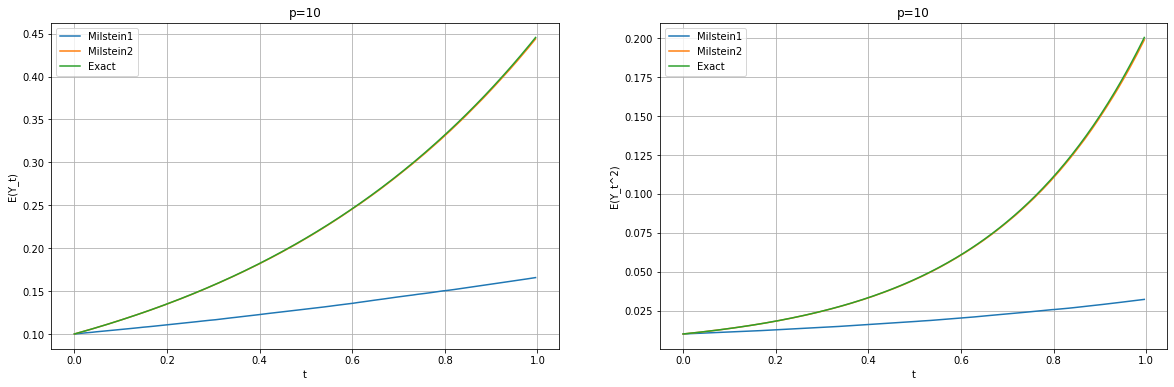

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(tvec, np.mean(yvec.numpy(), axis=0)[0,:], label='Milstein1')
plt.plot(tvec, np.mean(yvec.numpy(), axis=0)[1,:], label='Milstein2')
plt.plot(tvec, xmoment1, label='Exact')
plt.legend()
plt.xlabel('t')
plt.ylabel('E(Y_t)')
plt.title(f'p={p}')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.mean(np.square(yvec.numpy()), axis=0)[0,:], label='Milstein1')
plt.plot(tvec, np.mean(np.square(yvec.numpy()), axis=0)[1,:], label='Milstein2')
plt.plot(tvec, xmoment2, label='Exact')
plt.xlabel('t')
plt.ylabel('E(Y_t^2)')
plt.title(f'p={p}')
plt.legend()
plt.grid()

In [ ]:
print(np.mean(np.abs(np.mean(yvec.numpy(), axis=0)[0,:] - xmoment1)), np.mean(np.abs(np.mean(np.square(yvec.numpy()), axis=0)[0,:] - xmoment2)))

0.0009445299039997019 0.0005921113206958832


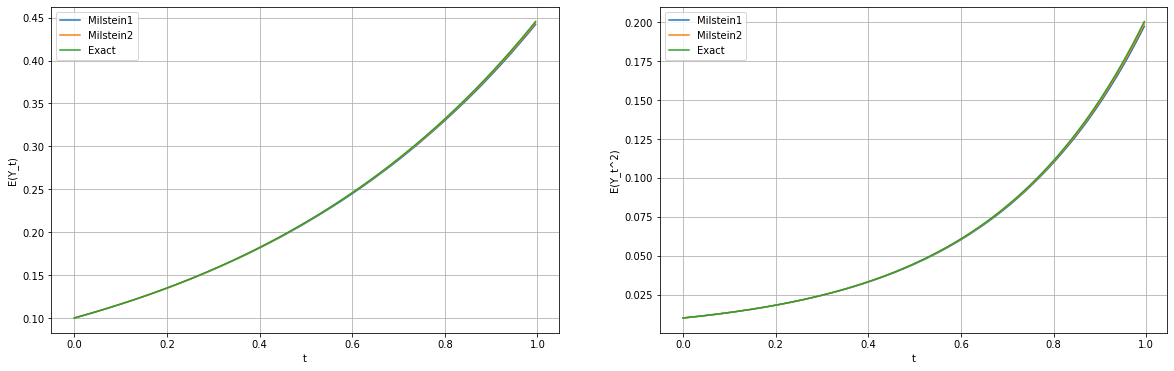

In [ ]:
predvec = emod(tf.cast(x0vec, dtype=tf.float32))

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(tvec, np.mean(predvec.numpy(), axis=0)[0,:], label='Milstein1')
plt.plot(tvec, np.mean(predvec.numpy(), axis=0)[1,:], label='Milstein2')
plt.plot(tvec, xmoment1, label='Exact')
plt.legend()
plt.xlabel('t')
plt.ylabel('E(Y_t)')
plt.grid()

plt.subplot(1,2,2)
plt.plot(tvec, np.mean(np.square(predvec.numpy()), axis=0)[0,:], label='Milstein1')
plt.plot(tvec, np.mean(np.square(predvec.numpy()), axis=0)[1,:], label='Milstein2')
plt.plot(tvec, xmoment2, label='Exact')
plt.xlabel('t')
plt.ylabel('E(Y_t^2)')
plt.legend()
plt.grid()